# Chapter 9 - Multimodal Large Language Models

## CLIP - Contrastive Language-Image Pretraining

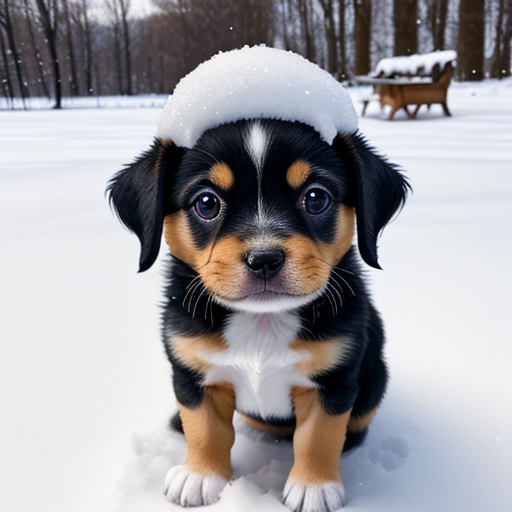

In [2]:
from urllib.request import urlopen
from PIL import Image

puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"
image

### Embeddings

In [13]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

In [5]:
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [7]:
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [8]:
processed_image = clip_processor(text=None, images=image, return_tensors="pt")['pixel_values']
processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(-0.5, 223.5, 223.5, -0.5)

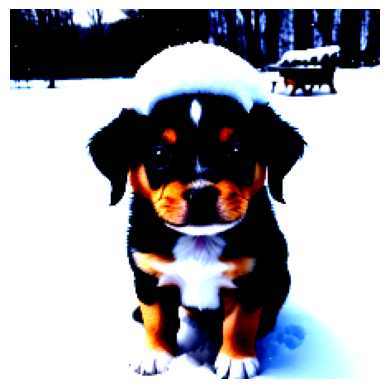

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum('ijk->jik', img)

plt.imshow(img)
plt.axis('off')


In [10]:
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [11]:
# normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# calculate the cosine similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
score

array([[0.33149642]], dtype=float32)

### More images

In [21]:
from urllib.request import urlopen
from PIL import Image
import numpy as np

cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
paths = [puppy_path, cat_path, car_path]
images = [Image.open(urlopen(path)).convert("RGB") for path in paths]
captions = [
    "a puppy playing in the snow",
    "a pixelated image of a cute cat",
    "A supercar on the road \nwith the sunset in the background",
]

image_embeddings = []
for image in images:
    image_processed = clip_processor(images=image, return_tensors="pt")['pixel_values']
    image_embedding = model.get_image_features(image_processed).detach().cpu().numpy()[0]
    image_embeddings.append(image_embedding)
image_embeddings = np.array(image_embeddings)

# embed the captions
text_embeddings = []
for caption in captions:
    inputs = clip_tokenizer(caption, return_tensors="pt")
    text_embedding = model.get_text_features(**inputs).detach().cpu().numpy()[0]
    text_embeddings.append(text_embedding)
text_embeddings = np.array(text_embeddings)


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

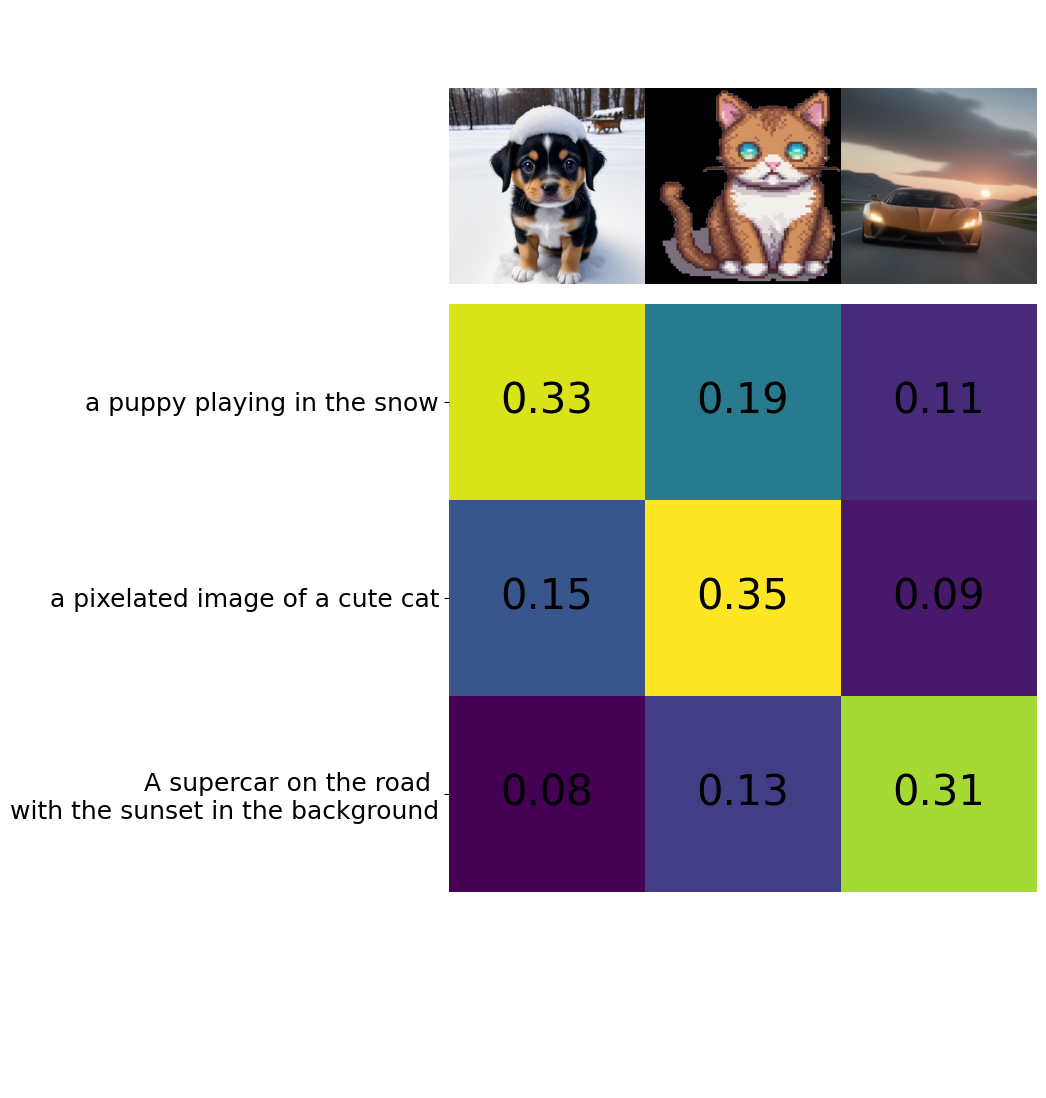

In [23]:
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# Adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# Visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# Remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')

### SBERT

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("clip-ViT-B-32")
image_embeddings = model.encode(images)
text_embeddings = model.encode(captions)

sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

## BLIP-2

In [1]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

blip_processor = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"
)

model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

cuda


### Preprocessing images

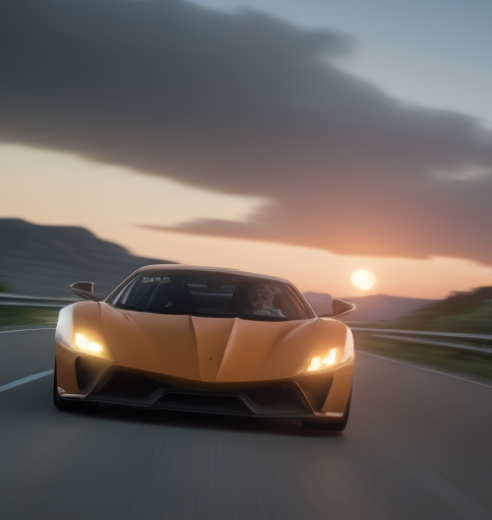

In [3]:
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [4]:
# Preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

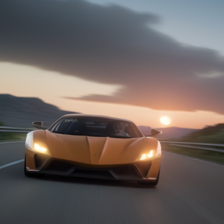

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Convert to numpy and go from (1, 3, 224, 224) to (224, 224, 3) in shape
image_inputs = inputs["pixel_values"][0].detach().cpu().numpy()
image_inputs = np.einsum('ijk->kji', image_inputs)
image_inputs = np.einsum('ijk->jik', image_inputs)

# Scale image inputs to 0-255 to represent RGB values
scaler = MinMaxScaler(feature_range=(0, 255))
image_inputs = scaler.fit_transform(image_inputs.reshape(-1, image_inputs.shape[-1])).reshape(image_inputs.shape)
image_inputs = np.array(image_inputs, dtype=np.uint8)

# Convert numpy array to Image
Image.fromarray(image_inputs)

### Preprocessing text

In [6]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [7]:
text = "Her vocalization was remarkable melodic"
token_ids = blip_processor(image, text=text, return_tensors='pt')
token_ids = token_ids.to(device, torch.float16)['input_ids'][0]

tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['</s>', 'Her', 'Ġvocal', 'ization', 'Ġwas', 'Ġremarkable', 'Ġmel', 'odic']

In [8]:
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['</s>', 'Her', '_vocal', 'ization', '_was', '_remarkable', '_mel', 'odic']

### Use case 1: Image captioning

In [9]:
inputs = blip_processor(image, return_tensors='pt').to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
generated_text

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'an orange supercar driving on the road at sunset'

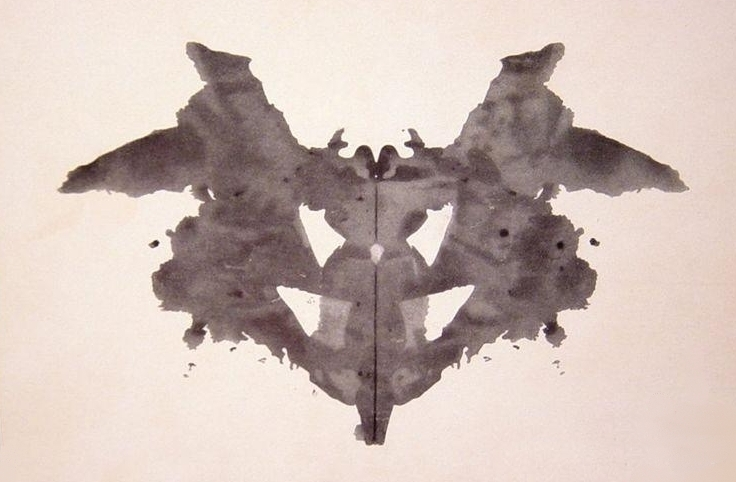

In [10]:
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")
image

In [11]:
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
generated_text

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'a black and white ink drawing of a bat'

### Use case 2: Visual question answering

In [13]:
image = Image.open(urlopen(car_path)).convert("RGB")

prompt = "Question: What is the color of the car? Answer:"
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
generated_text

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'Orange'

In [14]:
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer:"

# Generate output
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=30) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'$1,000,000'

In [15]:
from IPython.display import display, HTML
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # Create prompt
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"

    # Generate text
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]

    # Update memory
    memory.append((question, generated_text))

    # Assign to output
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)